In [40]:
import numpy as np

class Bandit:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.pulls = 0
        self.totalReward = 0

    def _sampleDistribution(self):
        return np.random.normal(self.mean, self.std)
    
    def pull(self):
        self.pulls += 1
        sample = self._sampleDistribution()
        self.totalReward += sample
        return sample
    
    def actionValue(self):
        if self.pulls > 0:
            return self.totalReward / self.pulls
        return 0
    
    def __lt__(self, other):
        return self.actionValue() < other.actionValue()
    
    def __gt__(self, other):
        return self.actionValue() > other.actionValue()
    
    def __eq__(self, other):
        return self.actionValue() == other.actionValue()


def egreedy(tester, hyperparam={"epsilon":0.1}):
        bandit = None

        if (np.random.uniform(0,1) < hyperparam['epsilon']):
            bandit = tester.bandits[np.random.randint(0, len(tester.bandits))]
        else:
            bandit = tester.bandits[np.argmax(tester.bandits)]
        return bandit

def ucb(tester, hyperparam={"C": 2}):
    return max(tester.bandits, key=lambda b: b.actionValue()+hyperparam['C']*(np.log((1 if tester.pulls == 0 else tester.pulls))/(1 if b.pulls == 0 else b.pulls)))

class Test:

    def __init__(self, steps, means):
        self.steps = steps
        self.rewards = [0]
        self.pulls = 0
        self.bestPossibleCumReward = [0]
        self.bandits = []
        self.correctBanditPulled = [0]
        for m in (means):
            mean = m
            std = 1
            bandit = Bandit(mean, std)
            self.bandits.append(bandit)
        
        self.bestBandit = max(self.bandits, key=lambda b: b.mean)
    
    def perform(self, banditChooser, hyperparams=None):
        while (self.pulls < self.steps):
            if hyperparams:
                bandit = banditChooser(self, hyperparams)
            else:
                 bandit = banditChooser(self)
            reward = bandit.pull()
            self.pulls += 1
            self.rewards.append(reward)

            if (bandit is self.bestBandit):
                self.correctBanditPulled.append(self.correctBanditPulled[-1] + 1)
                self.bestPossibleCumReward.append(self.bestPossibleCumReward[-1]+reward)
            else:
                self.correctBanditPulled.append(self.correctBanditPulled[-1])
                self.bestPossibleCumReward.append(self.bestPossibleCumReward[-1]+self.bestBandit._sampleDistribution())
    
    def stats(self):
        stats = {}
        stats['rewards'] = np.array(self.rewards)
        stats['correctBanditPulled'] = np.array(self.correctBanditPulled)
        return stats

In [41]:
def experiment(experiments, steps, nBandits, tests):
    means = [np.random.uniform(-2,2) for i in range(nBandits)]
    results = {}

    for test in tests:
       for i in range(experiments):
            tt = Test(steps, means)
            tt.perform(test["method"])
            stats = tt.stats()
            if test["name"] not in results:
                results[test["name"]] = stats
            else:
                results[test["name"]]['rewards'] = (results[test["name"]]['rewards'] + (stats['rewards']-results[test["name"]]['rewards'])/(i+1))
                results[test["name"]]['correctBanditPulled'] = (results[test["name"]]['correctBanditPulled'] + (stats['correctBanditPulled']-results[test["name"]]['correctBanditPulled'])/(i+1)) 
    
    return results

In [42]:
tests = [{
    "name":'epsilon',
    "method": egreedy,
},
{
    "name":'ucb',
    "method": ucb
}]

results = experiment(200,1000,10,tests)


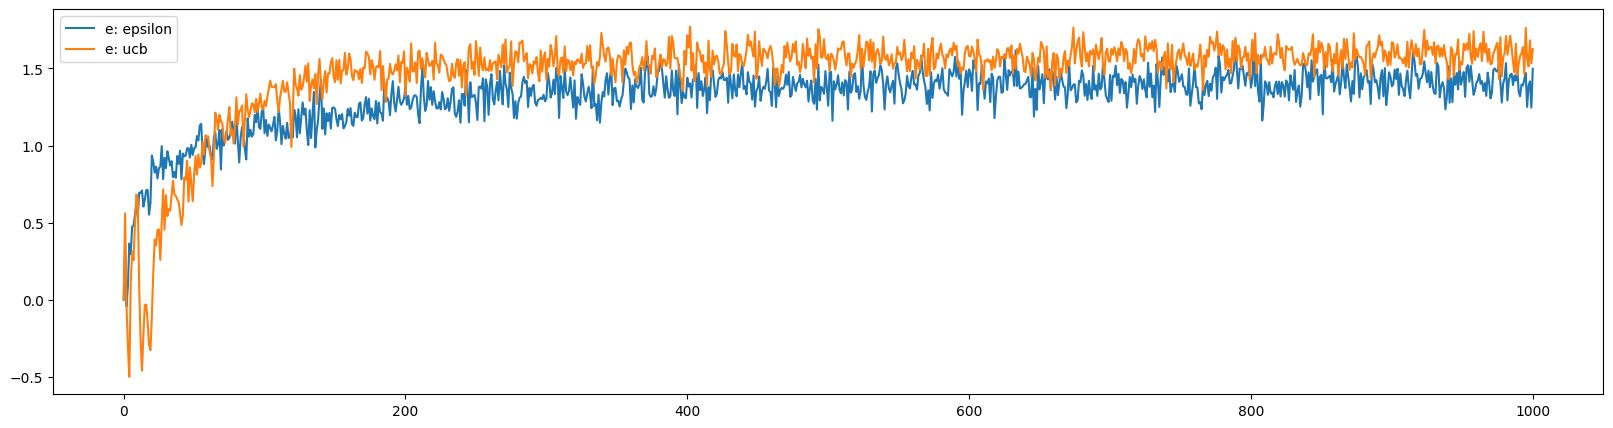

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for e,data in results.items():
    y = data['rewards']
    x = np.arange(0, len(y))
    plt.plot(x, y, label=f"e: {e}")
plt.legend()
plt.show()
